In [ ]:
!pip install scikit-learn==0.24

In [ ]:
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import *
from ast import literal_eval
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score as CVS
from sklearn.model_selection import KFold
from sklearn.linear_model import *
from sklearn import linear_model 
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_classif
import lightgbm as lgb

## Import Data

In [ ]:
#Import Files
from google.colab import files
uploaded = files.upload()

Saving item.csv to item.csv
Saving train.csv to train.csv


In [ ]:
#Read data
df_item = pd.read_csv('item.csv', parse_dates=True)
df_train = pd.read_csv('train.csv', parse_dates=True)
print(df_item)
print(df_train)

     item_id brand_id  brandfamily_id  package_id info_id
0          1  [6, 14]               1           1     BHS
1          6  [6, 19]               2           1     BHM
2         54  [6, 14]               1           1     BHS
3         15  [6, 19]               2           1     BHM
4        108     [19]               3           1     MQB
..       ...      ...             ...         ...     ...
113       78   [6, 8]               4           4    BZMN
114        5     [11]               5           1     HGO
115       83     [19]               3           1     MQB
116       87     [19]               3           2     MQB
117       12     [19]               3           4     MQB

[118 rows x 5 columns]
          datetime  order_id  user_id  item_id  province_id  city_id  quantity
0       2017-01-02      8806      404        1            2       19  8.298021
1       2017-01-02     22552      404        1            2       19  8.298021
2       2017-01-02       494      489      

## Data Preprocessing

In [ ]:
#Data integrity
df_wine = pd.merge(df_item,df_train, on = 'item_id')
df_wine

,item_id,brand_id,brandfamily_id,package_id,info_id,datetime,order_id,user_id,province_id,city_id,quantity
0,1,"[6, 14]",1,1,BHS,2017-01-02,8806,404,2,19,8.298021
1,1,"[6, 14]",1,1,BHS,2017-01-02,22552,404,2,19,8.298021
2,1,"[6, 14]",1,1,BHS,2017-01-06,54066,395,0,10,0.377183
3,1,"[6, 14]",1,1,BHS,2017-01-07,67828,377,0,4,0.754366
4,1,"[6, 14]",1,1,BHS,2017-01-10,4205,349,0,9,3.017462
...,...,...,...,...,...,...,...,...,...,...,...
145190,12,[19],3,4,MQB,2020-09-21,52082,18,0,10,3.643725
145191,12,[19],3,4,MQB,2020-09-26,11453,450,0,10,1.457490
145192,12,[19],3,4,MQB,2020-09-11,58771,262,0,10,2.914980
145193,12,[19],3,4,MQB,2020-09-12,33368,248,0,10,1.457490


The join result get a table with 145195 rows and 11 columns, which is good

In [ ]:
#Explode composite values
df_wine['brand_id'] = df_wine['brand_id'].astype(str)
df_wine['brand_id'] = df_wine['brand_id'].apply(literal_eval)
df_wine = df_wine.explode('brand_id')
df_wine

,item_id,brand_id,brandfamily_id,package_id,info_id,datetime,order_id,user_id,province_id,city_id,quantity
0,1,6,1,1,BHS,2017-01-02,8806,404,2,19,8.298021
0,1,14,1,1,BHS,2017-01-02,8806,404,2,19,8.298021
1,1,6,1,1,BHS,2017-01-02,22552,404,2,19,8.298021
1,1,14,1,1,BHS,2017-01-02,22552,404,2,19,8.298021
2,1,6,1,1,BHS,2017-01-06,54066,395,0,10,0.377183
...,...,...,...,...,...,...,...,...,...,...,...
145190,12,19,3,4,MQB,2020-09-21,52082,18,0,10,3.643725
145191,12,19,3,4,MQB,2020-09-26,11453,450,0,10,1.457490
145192,12,19,3,4,MQB,2020-09-11,58771,262,0,10,2.914980
145193,12,19,3,4,MQB,2020-09-12,33368,248,0,10,1.457490


We find that brand_id has composite items(it is a list), wh need to change its types to numeric. Explode the lists to get more rows(217723)

In [ ]:
df_wine.dtypes

item_id             int64
brand_id           object
brandfamily_id      int64
package_id          int64
info_id            object
datetime           object
order_id            int64
user_id             int64
province_id         int64
city_id             int64
quantity          float64
dtype: object

We check types, find most types are fine

In [ ]:
df_wine['datetime'] = pd.to_datetime(df_wine['datetime'])
df_wine.insert(0, 'Month',   df_wine['datetime'].dt.month)
df_wine.insert(0 , 'Year',  df_wine['datetime'].dt.year)

In [ ]:
df_wine.set_index('datetime')
df_wine = df_wine.set_index('datetime')
df_wine

,Year,Month,item_id,brand_id,brandfamily_id,package_id,info_id,order_id,user_id,province_id,city_id,quantity
datetime,,,,,,,,,,,,
2017-01-02,2017,1,1,6,1,1,BHS,8806,404,2,19,8.298021
2017-01-02,2017,1,1,14,1,1,BHS,8806,404,2,19,8.298021
2017-01-02,2017,1,1,6,1,1,BHS,22552,404,2,19,8.298021
2017-01-02,2017,1,1,14,1,1,BHS,22552,404,2,19,8.298021
2017-01-06,2017,1,1,6,1,1,BHS,54066,395,0,10,0.377183
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2020,9,12,19,3,4,MQB,52082,18,0,10,3.643725
2020-09-26,2020,9,12,19,3,4,MQB,11453,450,0,10,1.457490
2020-09-11,2020,9,12,19,3,4,MQB,58771,262,0,10,2.914980


We set date as index as it can not be used as features. We also extract month and year as they are useful information

In [ ]:
#Convert types 
df_wine['brand_id'] = df_wine['brand_id'].astype(int)
df_wine['info_id'] = df_wine['info_id'].astype('category')
df_wine.dtypes

Year                 int64
Month                int64
item_id              int64
brand_id             int64
brandfamily_id       int64
package_id           int64
info_id           category
order_id             int64
user_id              int64
province_id          int64
city_id              int64
quantity           float64
dtype: object

In [ ]:
# Convert string id to numeric 
df_wine['info_id'] = df_wine['info_id'].cat.codes

In [ ]:
df_wine['info_id'] = df_wine['info_id'].astype(int)
df_wine.dtypes

Year                int64
Month               int64
item_id             int64
brand_id            int64
brandfamily_id      int64
package_id          int64
info_id             int64
order_id            int64
user_id             int64
province_id         int64
city_id             int64
quantity          float64
dtype: object

We try to make sure every id is int. Convert brand_id to int. Cast info_id into category then convert into int. Convert the datetime from object to datetime object.

In [ ]:
#Cleaning NA values

df_wine.dropna(axis = 0, how = "any")
df_wine

,Year,Month,item_id,brand_id,brandfamily_id,package_id,info_id,order_id,user_id,province_id,city_id,quantity
datetime,,,,,,,,,,,,
2017-01-02,2017,1,1,6,1,1,3,8806,404,2,19,8.298021
2017-01-02,2017,1,1,14,1,1,3,8806,404,2,19,8.298021
2017-01-02,2017,1,1,6,1,1,3,22552,404,2,19,8.298021
2017-01-02,2017,1,1,14,1,1,3,22552,404,2,19,8.298021
2017-01-06,2017,1,1,6,1,1,3,54066,395,0,10,0.377183
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2020,9,12,19,3,4,11,52082,18,0,10,3.643725
2020-09-26,2020,9,12,19,3,4,11,11453,450,0,10,1.457490
2020-09-11,2020,9,12,19,3,4,11,58771,262,0,10,2.914980


In [ ]:
#Check negative values


print("The unusual values for item id:",df_wine[ df_wine.iloc[: , 0] < 0 ])
print("The unusual values for brand id:",df_wine[ df_wine.iloc[: , 1] < 0 ])
print("The unusual values for brandfamily id:",df_wine[ df_wine.iloc[: , 2] < 0 ])
print("The unusual values for package id:",df_wine[ df_wine.iloc[: , 3] < 0 ])
print("The unusual values for infor id:",df_wine[ df_wine.iloc[: , 4] < 0 ])
print("The unusual values for order id:",df_wine[ df_wine.iloc[: , 5] < 0 ])
print("The unusual values for user id:",df_wine[ df_wine.iloc[: , 6] < 0 ])
print("The unusual values for province id:",df_wine[ df_wine.iloc[: , 7] < 0 ])
print("The unusual values for city id:",df_wine[ df_wine.iloc[: , 8] < 0 ])
print("The unusual values for quantity :",df_wine[ df_wine.iloc[: , 9] < 0 ])


The unusual values for item id: Empty DataFrame
Columns: [Year, Month, item_id, brand_id, brandfamily_id, package_id, info_id, order_id, user_id, province_id, city_id, quantity]
Index: []
The unusual values for brand id: Empty DataFrame
Columns: [Year, Month, item_id, brand_id, brandfamily_id, package_id, info_id, order_id, user_id, province_id, city_id, quantity]
Index: []
The unusual values for brandfamily id: Empty DataFrame
Columns: [Year, Month, item_id, brand_id, brandfamily_id, package_id, info_id, order_id, user_id, province_id, city_id, quantity]
Index: []
The unusual values for package id: Empty DataFrame
Columns: [Year, Month, item_id, brand_id, brandfamily_id, package_id, info_id, order_id, user_id, province_id, city_id, quantity]
Index: []
The unusual values for infor id: Empty DataFrame
Columns: [Year, Month, item_id, brand_id, brandfamily_id, package_id, info_id, order_id, user_id, province_id, city_id, quantity]
Index: []
The unusual values for order id: Empty DataFrame

## EDA

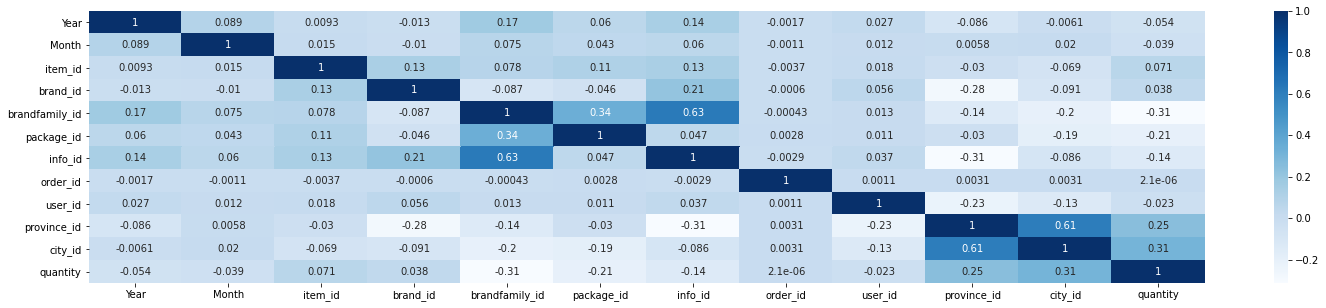

In [ ]:
plt.figure(figsize=(25,5))
sns.heatmap(df_wine.corr(), annot=True, cmap="Blues")



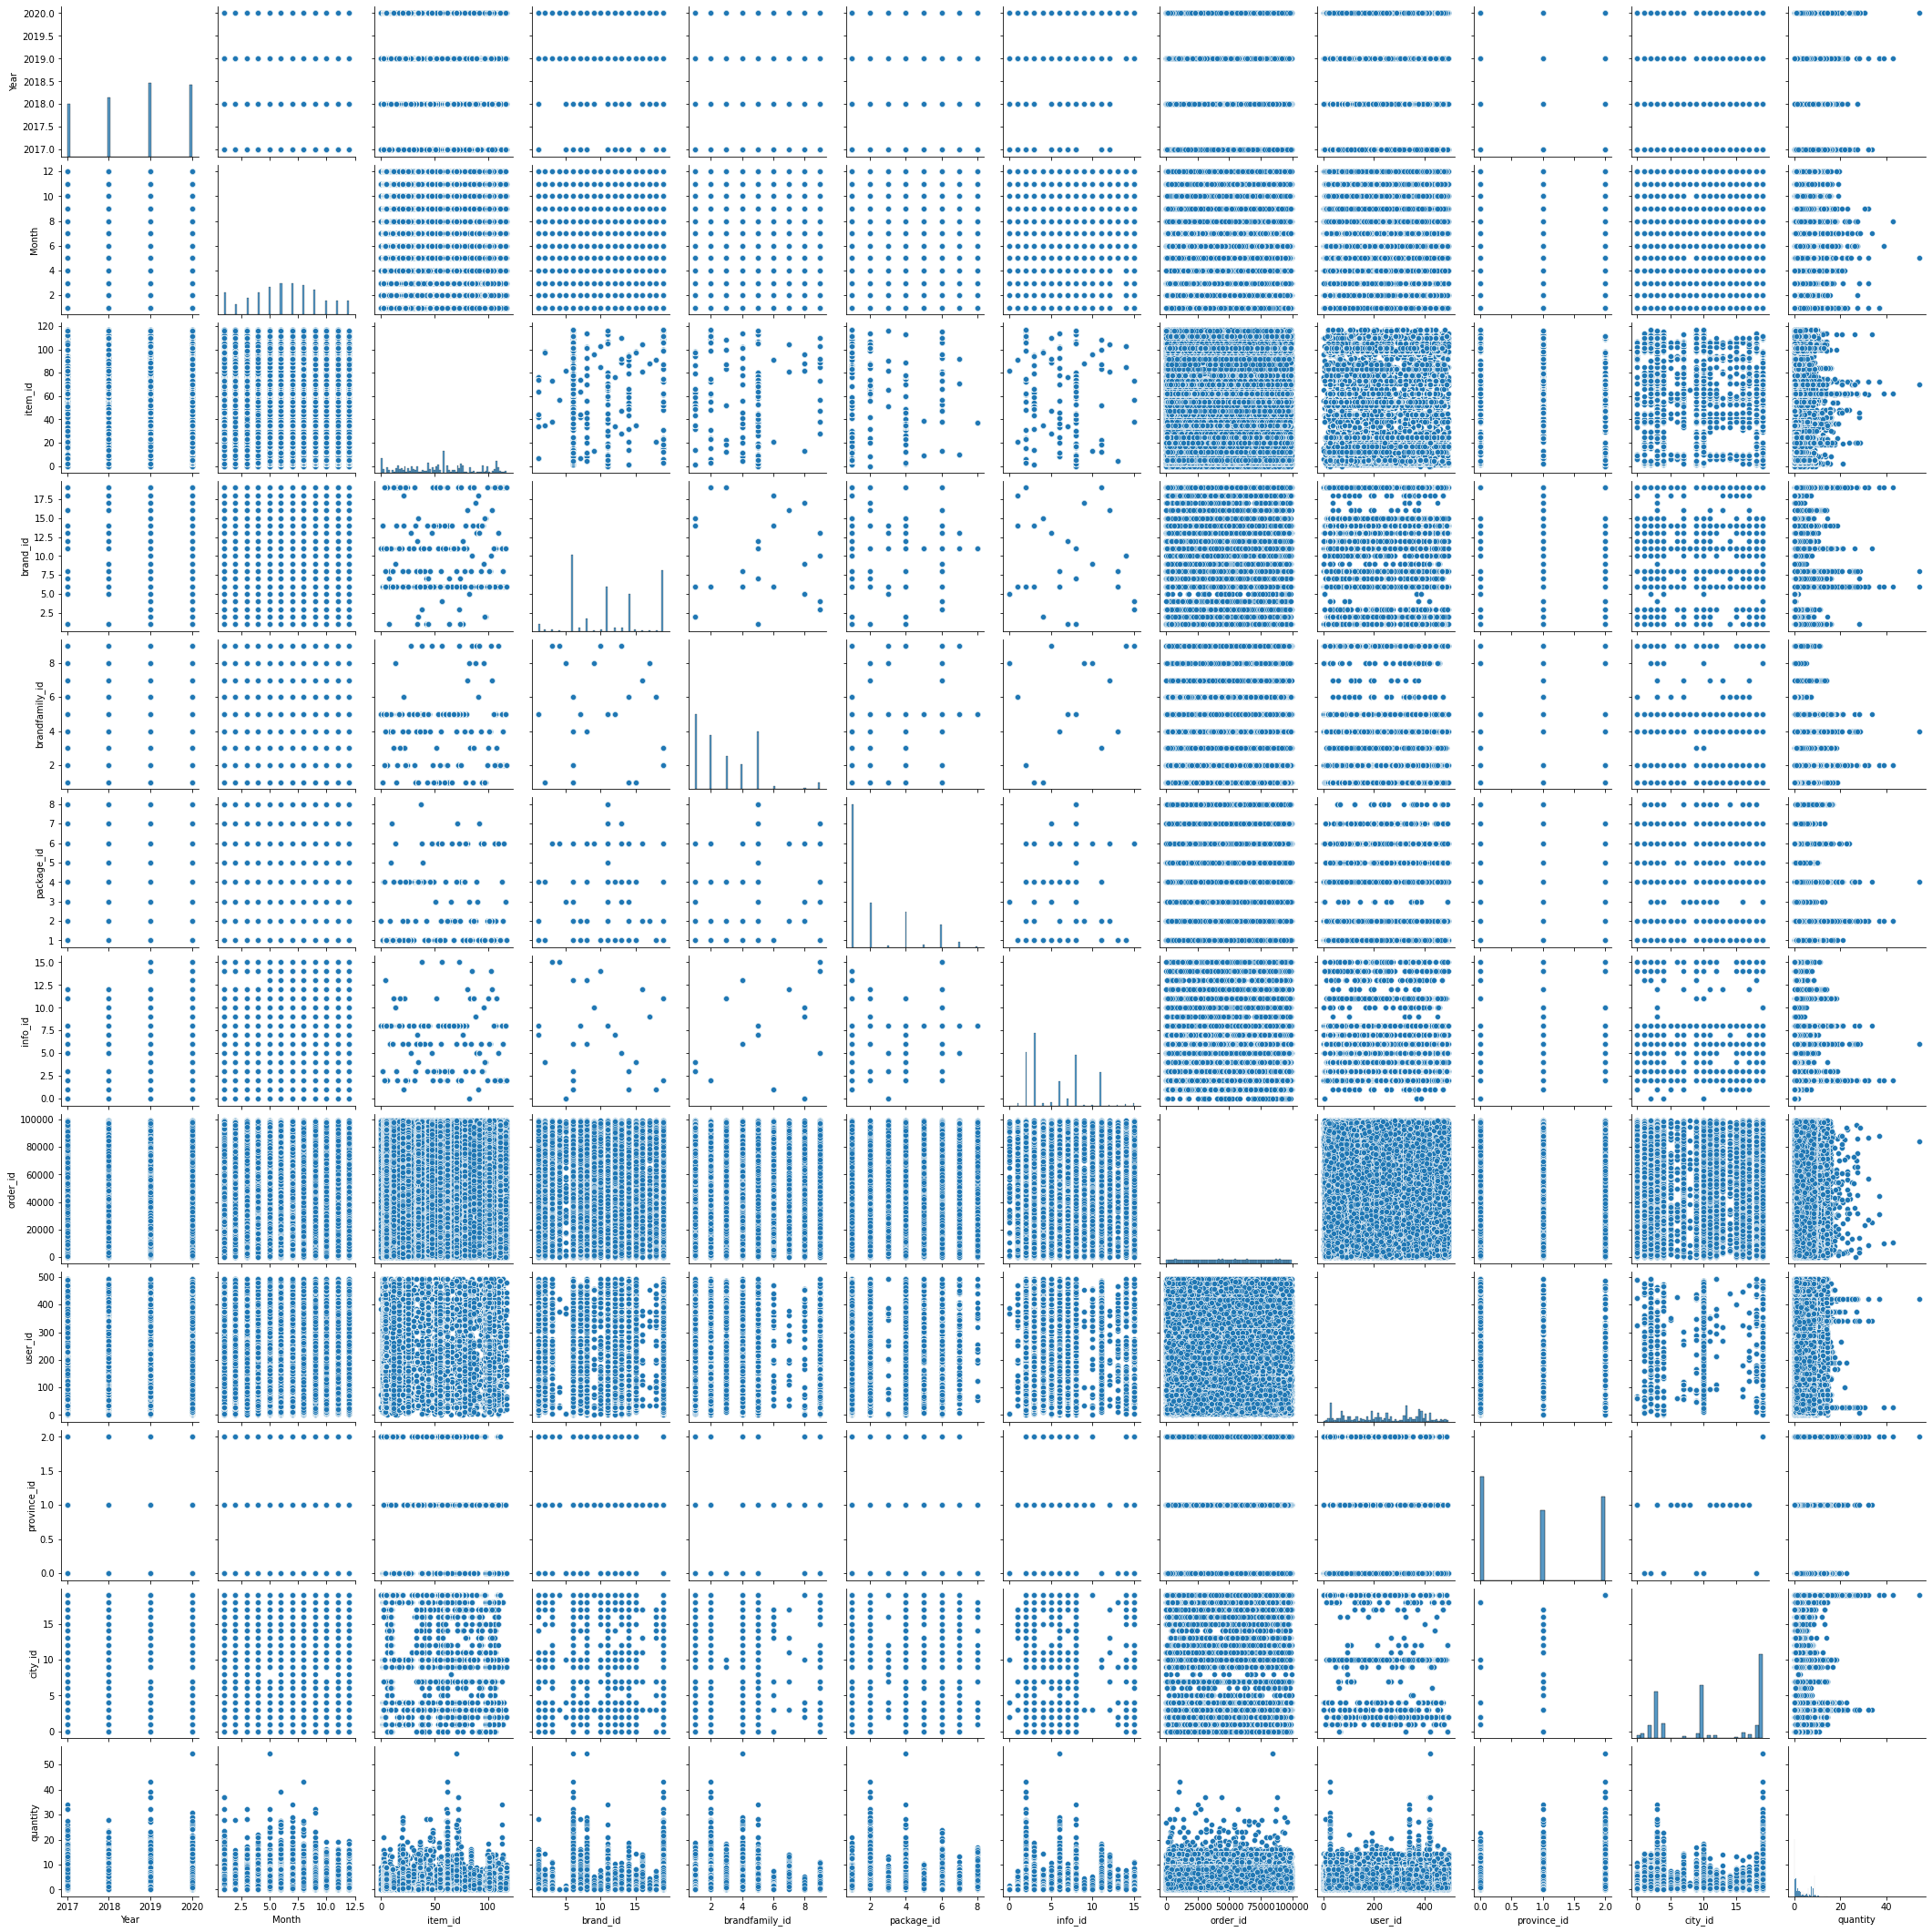

In [ ]:
sns.pairplot(df_wine)

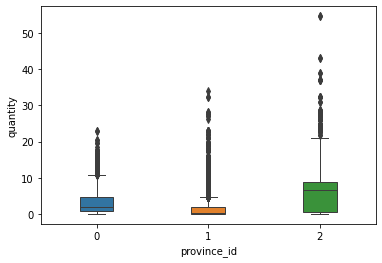

In [ ]:
sns.boxplot(x = 'province_id', y='quantity', data=df_wine , width = 0.3, linewidth = 1)

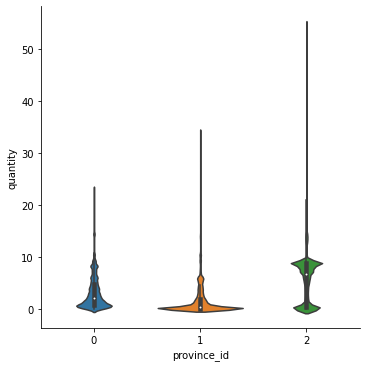

In [ ]:
# Violin plots
sns.catplot(x = 'province_id', y='quantity', data=df_wine, kind="violin")

We draw the box and violin plot on our target with one feature.  Obviouslly the graphs look not normal and has a lot of outliers and one side, we need to handle them immediatelly

In [ ]:
Q1 = df_wine['quantity'].quantile(0.25)
Q3 = df_wine['quantity'].quantile(0.75)
IQR = Q3 - Q1
index = df_wine[(df_wine['quantity'] < (Q1 - 1.5 * IQR)) |(df_wine['quantity'] > (Q3 + 1.5 * IQR))].index
df_wine.drop(index, inplace=True)
df_wine

,Year,Month,item_id,brand_id,brandfamily_id,package_id,info_id,order_id,user_id,province_id,city_id,quantity
datetime,,,,,,,,,,,,
2017-01-02,2017,1,1,6,1,1,3,8806,404,2,19,8.298021
2017-01-02,2017,1,1,14,1,1,3,8806,404,2,19,8.298021
2017-01-02,2017,1,1,6,1,1,3,22552,404,2,19,8.298021
2017-01-02,2017,1,1,14,1,1,3,22552,404,2,19,8.298021
2017-01-06,2017,1,1,6,1,1,3,54066,395,0,10,0.377183
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2020,9,12,19,3,4,11,52082,18,0,10,3.643725
2020-09-26,2020,9,12,19,3,4,11,11453,450,0,10,1.457490
2020-09-11,2020,9,12,19,3,4,11,58771,262,0,10,2.914980


Through outliers drop we remove around  1100 rows through the IQR rule. We then check through visulization agian.

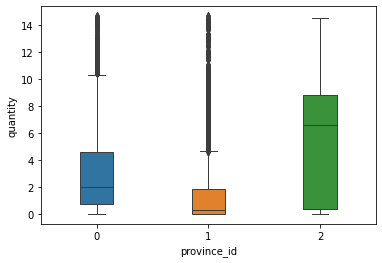

In [ ]:
sns.boxplot(x = 'province_id', y='quantity', data=df_wine , width = 0.3, linewidth = 1)

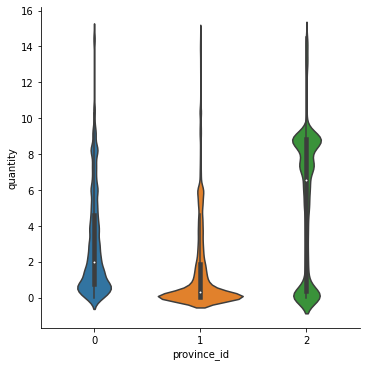

In [ ]:
sns.catplot(x = 'province_id', y='quantity', data=df_wine, kind="violin")

We still get some quantities whcih are large. However, the overall perfomence is much better. There are much fewer values are outliers

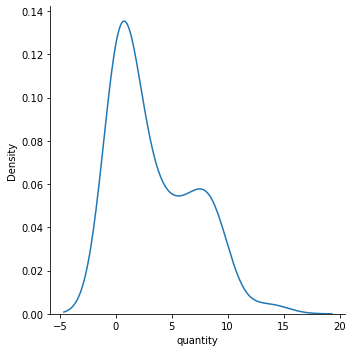

In [ ]:
#Data Visulization

sns.displot(df_wine, x='quantity', kind = 'kde',bw_adjust = 5)

From density plot of quantity, we see that most quantity are small and near 0, only a small part are large

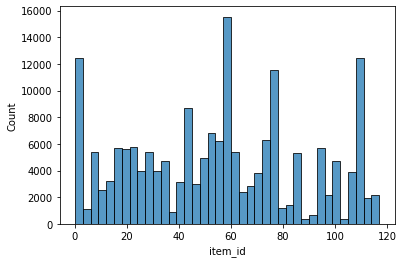

In [ ]:
sns.histplot(df_wine, x='item_id', binwidth = 3, bins=df_wine['item_id'].nunique())

We plot the histgrams through id and find there is huge difference between each item.

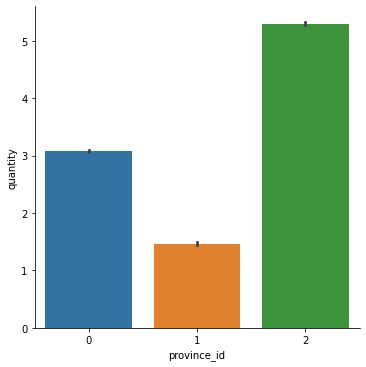

In [ ]:
sns.catplot(x='province_id', y='quantity', kind="bar", data=df_wine)

Use bar chart we find that province 2 has most quantities, follwed by province 0. Province 1 has least quantity.

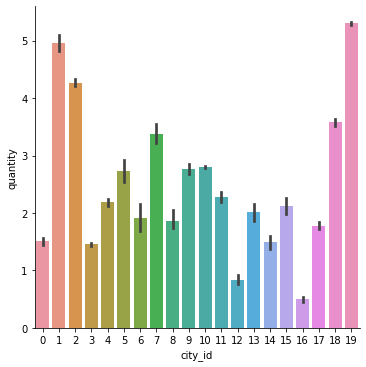

In [ ]:
sns.catplot( x='city_id',y='quantity',kind="bar", data=df_wine)

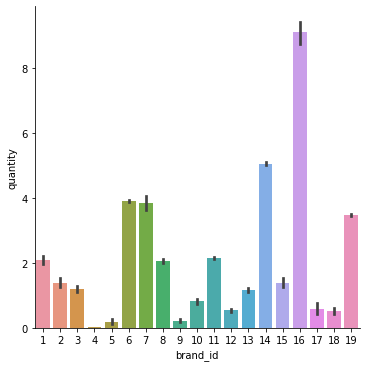

In [ ]:
sns.catplot( x='brand_id',y='quantity',kind="bar", data=df_wine)

We find that there are huge quantities difference between each city， there are also some diffrences between each brand

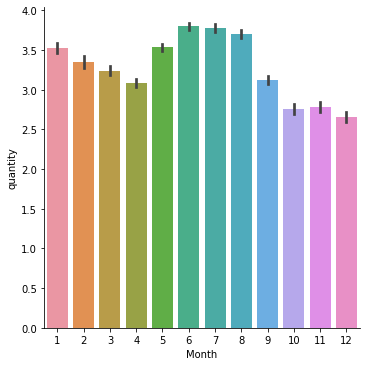

In [ ]:
sns.catplot( x='Month',y='quantity',kind="bar", data=df_wine)

There is not much difference on the sale between each month. We can see in the winter the sale is not that good as other season

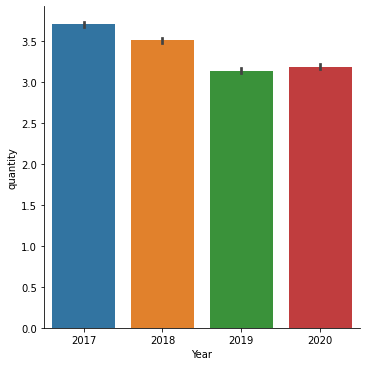

In [ ]:
sns.catplot( x='Year',y='quantity',kind="bar", data=df_wine)

The overall trend is decreasing. We find that even if we have Covid-19 in 2020, the overall sale did not decrease a lot from 2019.

## Model Preprocessing

In [ ]:
features = df_wine.iloc[:,0:11]
features

,Year,Month,item_id,brand_id,brandfamily_id,package_id,info_id,order_id,user_id,province_id,city_id
datetime,,,,,,,,,,,
2017-01-02,2017,1,1,6,1,1,3,8806,404,2,19
2017-01-02,2017,1,1,14,1,1,3,8806,404,2,19
2017-01-02,2017,1,1,6,1,1,3,22552,404,2,19
2017-01-02,2017,1,1,14,1,1,3,22552,404,2,19
2017-01-06,2017,1,1,6,1,1,3,54066,395,0,10
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2020,9,12,19,3,4,11,52082,18,0,10
2020-09-26,2020,9,12,19,3,4,11,11453,450,0,10
2020-09-11,2020,9,12,19,3,4,11,58771,262,0,10


In [ ]:
target = df_wine.iloc[:,11]
target

datetime
2017-01-02    8.298021
2017-01-02    8.298021
2017-01-02    8.298021
2017-01-02    8.298021
2017-01-06    0.377183
                ...   
2020-09-21    3.643725
2020-09-26    1.457490
2020-09-11    2.914980
2020-09-12    1.457490
2020-09-19    0.728745
Name: quantity, Length: 217723, dtype: float64

We split data into features and target

In [ ]:
train = df_wine[df_wine['Year'].isin([2019, 2018,2017])]
X_train = train.iloc[:,0:11]
y_train = train.iloc[:,11]
val = df_wine[df_wine['Year'].isin([2020])]
X_val = val.iloc[:,0:11]
y_val = val.iloc[:,11]
print(train.shape)
print(val.shape)

(157269, 12)
(60454, 12)


We split data sets into train set with year 2017, 2018, 2019, validation set with year 2020 in convenience of forcasting.

In [ ]:
std_x = StandardScaler()
X_std_train = std_x.fit_transform(X_train)
X_std_val = std_x.fit_transform(X_val)

Add scaled variables in advance 

In [ ]:
df_new = df_wine.copy()
df_new.insert(0, 'date', pd.to_datetime(df_wine[['Year', 'Month']].assign(DAY=1))) 
new_data = pd.DataFrame(columns = ['date', 'new_quantity'])
new_data['date'] = y_val.index
new_data.insert(0, 'month',  new_data['date'].dt.month) 
new_data.insert(0, 'year',  new_data['date'].dt.year) 
new_data['datetime'] = pd.to_datetime(new_data[['year', 'month']].assign(DAY=1)) 

## Model 1 KNN 

We normalize data as it is necessary for knn

In [ ]:

df_results = pd.DataFrame(columns = ['k','weights','alogorithm', 'mae','rmse'])
count = 0
ks = [2,5,8,12,15,20]
for i in ks:
  for weight in ['uniform', 'distance']:
    for algorithm in ['auto', 'ball_tree', 'kd_tree', 'brute']:
      knn = KNeighborsRegressor(n_neighbors=i, weights=  weight, algorithm= algorithm)
      model = knn.fit(X_std_train, y_train) 
      pred = model.predict(X_std_val)
      mae =  mean_absolute_error(y_val, pred)
      rmse = mean_squared_error(y_val, pred, squared=False)
      df_results.loc[count] = [i ,weight,algorithm, mae,  rmse]
      count = count + 1



In [ ]:
print(tabulate(df_results, headers=df_results.columns, tablefmt='grid'))

print('Best performing model')      
print(tabulate(df_results[df_results['rmse']==df_results['rmse'].min()], headers = 'keys', tablefmt = 'psql'))

+----+-----+-----------+--------------+---------+---------+
|    |   k | weights   | alogorithm   |     mae |    rmse |
+====+=====+===========+==============+=========+=========+
|  0 |   2 | uniform   | auto         | 2.33838 | 3.50283 |
+----+-----+-----------+--------------+---------+---------+
|  1 |   2 | uniform   | ball_tree    | 2.33815 | 3.50251 |
+----+-----+-----------+--------------+---------+---------+
|  2 |   2 | uniform   | kd_tree      | 2.33838 | 3.50283 |
+----+-----+-----------+--------------+---------+---------+
|  3 |   2 | uniform   | brute        | 2.33853 | 3.50301 |
+----+-----+-----------+--------------+---------+---------+
|  4 |   2 | distance  | auto         | 2.33805 | 3.50342 |
+----+-----+-----------+--------------+---------+---------+
|  5 |   2 | distance  | ball_tree    | 2.33781 | 3.50312 |
+----+-----+-----------+--------------+---------+---------+
|  6 |   2 | distance  | kd_tree      | 2.33805 | 3.50342 |
+----+-----+-----------+--------------+-

We find that the best K is 20, rmse is 3.15, weight is distance, alogorithm is ball_tree

In [ ]:
knn = KNeighborsRegressor(n_neighbors=20, weights=  'distance', algorithm= 'ball_tree')
model = knn.fit(X_std_train, y_train) 
pred_knn = model.predict(X_std_val)

Get best model results once agian for visulization

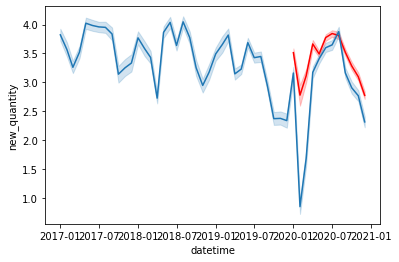

In [ ]:
new_data['new_quantity'] = pred_knn
sns.lineplot(data = new_data, x='datetime', y='new_quantity', color= 'r')
sns.lineplot(data = df_new, x='date', y='quantity')

Visulize our forecast result

## Model 2 Random Forest

In [ ]:
df_results = pd.DataFrame(columns = ['n','depth', 'mae','rmse'])
depths  =  [10,20,40, 60 ,80]
n_estimators =   [10, 20 ,40, 60, 80 ,100]
count = 0


for depth in depths:
    for n in n_estimators:
        rf = RandomForestRegressor(max_depth = depth, n_estimators = n,random_state= 9)
        model = rf.fit(X_train, y_train) 
        pred = model.predict(X_val)
        mae =  mean_absolute_error(y_val, pred)
        rmse = mean_squared_error(y_val, pred, squared=False)
        df_results.loc[count] = [n ,depth, mae,  rmse]
        count = count + 1

       

In [ ]:
print(tabulate(df_results, headers=df_results.columns, tablefmt='grid'))

print('Best performing model')      
print(tabulate(df_results[df_results['rmse']==df_results['rmse'].min()], headers = 'keys', tablefmt = 'psql'))

+----+-----+---------+---------+---------+
|    |   n |   depth |     mae |    rmse |
+====+=====+=========+=========+=========+
|  0 |  10 |      10 | 1.6998  | 2.82827 |
+----+-----+---------+---------+---------+
|  1 |  20 |      10 | 1.72191 | 2.92219 |
+----+-----+---------+---------+---------+
|  2 |  40 |      10 | 1.71137 | 2.87185 |
+----+-----+---------+---------+---------+
|  3 |  60 |      10 | 1.70265 | 2.84147 |
+----+-----+---------+---------+---------+
|  4 |  80 |      10 | 1.70245 | 2.82092 |
+----+-----+---------+---------+---------+
|  5 | 100 |      10 | 1.70426 | 2.84433 |
+----+-----+---------+---------+---------+
|  6 |  10 |      20 | 1.60026 | 2.91648 |
+----+-----+---------+---------+---------+
|  7 |  20 |      20 | 1.61287 | 3.01174 |
+----+-----+---------+---------+---------+
|  8 |  40 |      20 | 1.61224 | 2.97711 |
+----+-----+---------+---------+---------+
|  9 |  60 |      20 | 1.59923 | 2.92888 |
+----+-----+---------+---------+---------+
| 10 |  80 

If we have n = 80 and max_depth is equal to 10, we get best model with rmse = 2.82


In [ ]:
rf = RandomForestRegressor(max_depth = 10, n_estimators = 80,random_state= 9)
model = rf.fit(X_train, y_train) 
pre_rf = model.predict(X_val)

In [ ]:
 new_data['new_quantity'] = pre_rf

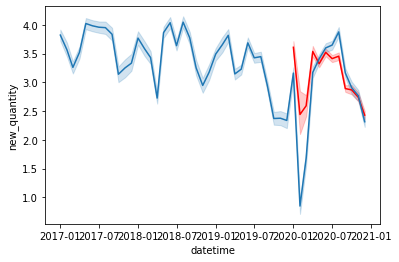

In [ ]:
sns.lineplot(data = new_data, x='datetime', y='new_quantity', color= 'r')
sns.lineplot(data = df_new, x='date', y='quantity')

## Model 3 Linear Regression

In [ ]:

df_results = pd.DataFrame(columns = ['fit','normalize', 'mae','rmse'])
count = 0

for fit in [True, False]:
    for nor in [True, False]:
        regr = linear_model.LinearRegression(fit_intercept = fit,normalize =nor)
        model = regr.fit(X_train, y_train) 
        pred = model.predict(X_val)
        mae =  mean_absolute_error(y_val, pred)
        rmse = mean_squared_error(y_val, pred, squared=False)
        df_results.loc[count] = [fit,nor, mae, rmse]
        count = count + 1


In [ ]:
print(tabulate(df_results, headers=df_results.columns, tablefmt='grid'))

print('Best performing model')      
print(tabulate(df_results[df_results['rmse']==df_results['rmse'].min()], headers = 'keys', tablefmt = 'psql'))

+----+-------+-------------+---------+---------+
|    | fit   | normalize   |     mae |    rmse |
+====+=======+=============+=========+=========+
|  0 | True  | True        | 2.59399 | 3.30431 |
+----+-------+-------------+---------+---------+
|  1 | True  | False       | 2.59399 | 3.30431 |
+----+-------+-------------+---------+---------+
|  2 | False | True        | 2.59548 | 3.30398 |
+----+-------+-------------+---------+---------+
|  3 | False | False       | 2.59548 | 3.30398 |
+----+-------+-------------+---------+---------+
Best performing model
+----+-------+-------------+---------+---------+
|    | fit   | normalize   |     mae |    rmse |
|----+-------+-------------+---------+---------|
|  2 | False | True        | 2.59548 | 3.30398 |
|  3 | False | False       | 2.59548 | 3.30398 |
+----+-------+-------------+---------+---------+


In [ ]:
alphas = np.arange(0, 5.5, 0.5)
df_results = pd.DataFrame(columns = ['alpha','fit','normalize', 'mae','rmse'])
parameters = {'alpha':alphas, 'fit_intercept': [True, False], 'normalize': [True, False]}
count = 0
for alpha in alphas:
    for fit in [True, False]:
        for nor in [True, False]:
            lasso = linear_model.Lasso(alpha = alpha, fit_intercept = fit,normalize = nor)
            model = lasso.fit(X_train, y_train) 
            pred = model.predict(X_val)
            mae =  mean_absolute_error(y_val, pred)
            rmse = mean_squared_error(y_val, pred, squared=False)
            df_results.loc[count] = [alpha, fit,nor, mae,  rmse]
            count = count + 1
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  fit_intercept=False, copy=False, check_input=check_input)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 806979.2124569955, tolerance: 205.4538714631622
  fit_intercept=False, copy=False, check_input=check_input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/usr/local

In [ ]:
print(tabulate(df_results, headers=df_results.columns, tablefmt='grid'))

print('Best performing model')      
print(tabulate(df_results[df_results['rmse']==df_results['rmse'].min()], headers = 'keys', tablefmt = 'psql'))

+----+---------+-------+-------------+---------+---------+
|    |   alpha | fit   | normalize   |     mae |    rmse |
+====+=========+=======+=============+=========+=========+
|  0 |     0   | True  | True        | 2.59399 | 3.30431 |
+----+---------+-------+-------------+---------+---------+
|  1 |     0   | True  | False       | 2.59399 | 3.30431 |
+----+---------+-------+-------------+---------+---------+
|  2 |     0   | False | True        | 2.59548 | 3.30398 |
+----+---------+-------+-------------+---------+---------+
|  3 |     0   | False | False       | 2.59548 | 3.30398 |
+----+---------+-------+-------------+---------+---------+
|  4 |     0.5 | True  | True        | 3.04152 | 3.52348 |
+----+---------+-------+-------------+---------+---------+
|  5 |     0.5 | True  | False       | 2.68159 | 3.30159 |
+----+---------+-------+-------------+---------+---------+
|  6 |     0.5 | False | True        | 2.68199 | 3.30173 |
+----+---------+-------+-------------+---------+--------

In [ ]:
alphas = np.arange(0, 5.5, 0.5)
df_results = pd.DataFrame(columns = ['alpha','fit','normalize', 'mae','rmse'])
count = 0
for alpha in alphas:
    for fit in [True, False]:
        for nor in [True, False]:
            ridge = linear_model.Ridge(alpha = alpha, fit_intercept= fit,normalize=nor)
            model = ridge.fit(X_train, y_train) 
            pred = model.predict(X_val)
            mae =  mean_absolute_error(y_val, pred)
            rmse = mean_squared_error(y_val, pred, squared=False)
            df_results.loc[count] = [alpha, fit,nor, mae,  rmse]
            count = count + 1

In [ ]:
print(tabulate(df_results, headers=df_results.columns, tablefmt='grid'))

print('Best performing model')      
print(tabulate(df_results[df_results['rmse']==df_results['rmse'].min()], headers = 'keys', tablefmt = 'psql'))

+----+---------+-------+-------------+---------+---------+
|    |   alpha | fit   | normalize   |     mae |    rmse |
+====+=========+=======+=============+=========+=========+
|  0 |     0   | True  | True        | 2.59399 | 3.30431 |
+----+---------+-------+-------------+---------+---------+
|  1 |     0   | True  | False       | 2.59399 | 3.30431 |
+----+---------+-------+-------------+---------+---------+
|  2 |     0   | False | True        | 2.59548 | 3.30398 |
+----+---------+-------+-------------+---------+---------+
|  3 |     0   | False | False       | 2.59548 | 3.30398 |
+----+---------+-------+-------------+---------+---------+
|  4 |     0.5 | True  | True        | 2.64431 | 3.28438 |
+----+---------+-------+-------------+---------+---------+
|  5 |     0.5 | True  | False       | 2.59399 | 3.30431 |
+----+---------+-------+-------------+---------+---------+
|  6 |     0.5 | False | True        | 2.59548 | 3.30398 |
+----+---------+-------+-------------+---------+--------

We try normal linear regression, lasso regression and ridge regression, and find that the best rmse is 3.284 
Best model is  ridge Regression （ alpha=0.5, fit_intercept=True， normalize=True )

In [ ]:
ridge = linear_model.Ridge(alpha = 0.5, fit_intercept= True,normalize= True)
model = ridge.fit(X_train, y_train) 
pred_lr = model.predict(X_val)

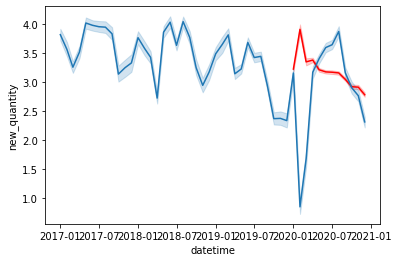

In [ ]:
new_data['new_quantity'] = pred_lr
sns.lineplot(data = new_data, x='datetime', y='new_quantity', color= 'r')
sns.lineplot(data = df_new, x='date', y='quantity')

## Model 4 Nerual Network

In [ ]:
df_results = pd.DataFrame(columns = ['leaning_rate','transfer_function', 'RMSE','MAE'])
lrs = [  0.001,  0.01, 0.1, 1]
transfer_functions = ['identity', 'logistic',  'relu']
count = 0
for lr in lrs:
  for tf in transfer_functions:
        nn = MLPRegressor(learning_rate_init= lr, activation=tf)
        model = nn.fit(X_std_train, y_train) 
        y_pred = model.predict(X_std_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mae = mean_absolute_error(y_val, y_pred)
        df_results.loc[count] = [lr,tf, rmse, mae]
        count = count + 1


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  # update weights
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  # update weights
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  # update weights


In [ ]:
print(tabulate(df_results, headers=df_results.columns, tablefmt='grid'))
print('Best performing model')      
print(tabulate(df_results[df_results['RMSE']==df_results['RMSE'].min()], headers = 'keys', tablefmt = 'psql'))

+----+----------------+---------------------+----------+----------+
|    |   leaning_rate | transfer_function   |     RMSE |      MAE |
+====+================+=====================+==========+==========+
|  0 |          0.001 | identity            |  3.30504 |  2.66757 |
+----+----------------+---------------------+----------+----------+
|  1 |          0.001 | logistic            |  3.37589 |  2.53129 |
+----+----------------+---------------------+----------+----------+
|  2 |          0.001 | relu                |  3.4973  |  2.55425 |
+----+----------------+---------------------+----------+----------+
|  3 |          0.01  | identity            |  3.31495 |  2.68734 |
+----+----------------+---------------------+----------+----------+
|  4 |          0.01  | logistic            |  3.56706 |  2.74311 |
+----+----------------+---------------------+----------+----------+
|  5 |          0.01  | relu                |  3.42882 |  2.46853 |
+----+----------------+---------------------+---

Through running best model reach RMSE 3.3, with learning rate 0.001, transfer function identity

In [ ]:
nn = MLPRegressor(learning_rate_init= 0.001, activation='identity')
model = nn.fit(X_std_train, y_train) 
pred_nn = model.predict(X_std_val)

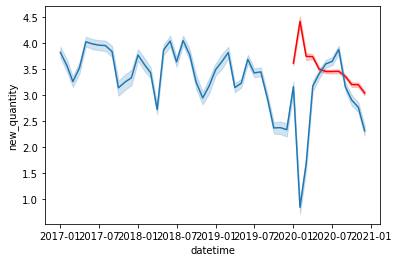

In [ ]:
new_data['new_quantity'] = pred_nn
sns.lineplot(data = new_data, x='datetime', y='new_quantity', color= 'r')
sns.lineplot(data = df_new, x='date', y='quantity')

## Model 5 LightGBM

In [ ]:
params = {
         "objective" : "regression",
         "metric" : "rmse",
         "num_leaves" : 64,
         "learning_rate" : 0.005,
         "bagging_fraction" : 0.7,
         "feature_fraction" : 0.5,
         "bagging_frequency" : 6,
         "bagging_seed" : 42,
         "verbosity" : 1,
         "seed": 42,
         }

lgtrain = lgb.Dataset(X_train, label= y_train)
lgval = lgb.Dataset(X_val, label=y_val)
evals_result = {}
model = lgb.train(params, lgtrain, 5000, 
                       valid_sets=[lgval], 
                       early_stopping_rounds=100, 
                       verbose_eval=50, 
                       evals_result=evals_result)
    
y_pred = model.predict(X_val, num_iteration=model.best_iteration)


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 3.2248
[100]	valid_0's rmse: 2.98539
[150]	valid_0's rmse: 2.8166
[200]	valid_0's rmse: 2.69746
[250]	valid_0's rmse: 2.61247
[300]	valid_0's rmse: 2.54861
[350]	valid_0's rmse: 2.49634
[400]	valid_0's rmse: 2.45041
[450]	valid_0's rmse: 2.41598
[500]	valid_0's rmse: 2.38642
[550]	valid_0's rmse: 2.36263
[600]	valid_0's rmse: 2.34131
[650]	valid_0's rmse: 2.32385
[700]	valid_0's rmse: 2.30888
[750]	valid_0's rmse: 2.29731
[800]	valid_0's rmse: 2.28521
[850]	valid_0's rmse: 2.27526
[900]	valid_0's rmse: 2.26463
[950]	valid_0's rmse: 2.25512
[1000]	valid_0's rmse: 2.24656
[1050]	valid_0's rmse: 2.24089
[1100]	valid_0's rmse: 2.23617
[1150]	valid_0's rmse: 2.2313
[1200]	valid_0's rmse: 2.22588
[1250]	valid_0's rmse: 2.22285
[1300]	valid_0's rmse: 2.21967
[1350]	valid_0's rmse: 2.21693
[1400]	valid_0's rmse: 2.21471
[1450]	valid_0's rmse: 2.21331
[1500]	valid_0's rmse: 2.21124
[1550]	valid_0's rmse: 2.20927

We got best rmse with 2.19033, which is already our best model!

In [ ]:
params = {
         "objective" : "regression",
         "metric" : "rmse",
         "num_leaves" : 100,
         "learning_rate" : 0.005,
         "bagging_fraction" : 0.7,
         "feature_fraction" : 0.5,
         "bagging_frequency" : 6,
         "bagging_seed" : 42,
         "verbosity" : 1,
         "seed": 42,
         }

lgtrain = lgb.Dataset(X_train, label= y_train)
lgval = lgb.Dataset(X_val, label=y_val)
evals_result = {}
model = lgb.train(params, lgtrain, 5000, 
                       valid_sets=[lgval], 
                       early_stopping_rounds=100, 
                       verbose_eval=50, 
                       evals_result=evals_result)
    
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 3.20978
[100]	valid_0's rmse: 2.95795
[150]	valid_0's rmse: 2.78136
[200]	valid_0's rmse: 2.65726
[250]	valid_0's rmse: 2.56931
[300]	valid_0's rmse: 2.50219
[350]	valid_0's rmse: 2.44832
[400]	valid_0's rmse: 2.40275
[450]	valid_0's rmse: 2.36887
[500]	valid_0's rmse: 2.34255
[550]	valid_0's rmse: 2.32059
[600]	valid_0's rmse: 2.30351
[650]	valid_0's rmse: 2.28901
[700]	valid_0's rmse: 2.2764
[750]	valid_0's rmse: 2.26589
[800]	valid_0's rmse: 2.25591
[850]	valid_0's rmse: 2.24886
[900]	valid_0's rmse: 2.24085
[950]	valid_0's rmse: 2.23393
[1000]	valid_0's rmse: 2.22726
[1050]	valid_0's rmse: 2.22304
[1100]	valid_0's rmse: 2.21907
[1150]	valid_0's rmse: 2.21571
[1200]	valid_0's rmse: 2.21197
[1250]	valid_0's rmse: 2.20964
[1300]	valid_0's rmse: 2.20729
[1350]	valid_0's rmse: 2.20566
[1400]	valid_0's rmse: 2.2042
[1450]	valid_0's rmse: 2.20323
[1500]	valid_0's rmse: 2.20199
[1550]	valid_0's rmse: 2.2004

Increase num_leaves , rmse got further improved 

In [ ]:
params = {
         "objective" : "regression",
         "metric" : "rmse",
         "num_leaves" : 100,
         "learning_rate" : 0.001,
         "bagging_fraction" : 0.7,
         "feature_fraction" : 0.5,
         "bagging_frequency" : 6,
         "bagging_seed" : 42,
         "verbosity" : 1,
         "seed": 42,
         }

lgtrain = lgb.Dataset(X_train, label= y_train)
lgval = lgb.Dataset(X_val, label=y_val)
evals_result = {}
model = lgb.train(params, lgtrain, 5000, 
                       valid_sets=[lgval], 
                       early_stopping_rounds=100, 
                       verbose_eval=50, 
                       evals_result=evals_result)
    
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 3.45317
[100]	valid_0's rmse: 3.38253
[150]	valid_0's rmse: 3.31824
[200]	valid_0's rmse: 3.25913
[250]	valid_0's rmse: 3.20629
[300]	valid_0's rmse: 3.15588
[350]	valid_0's rmse: 3.1065
[400]	valid_0's rmse: 3.05828
[450]	valid_0's rmse: 3.0148
[500]	valid_0's rmse: 2.97164
[550]	valid_0's rmse: 2.93207
[600]	valid_0's rmse: 2.8958
[650]	valid_0's rmse: 2.85937
[700]	valid_0's rmse: 2.82791
[750]	valid_0's rmse: 2.79605
[800]	valid_0's rmse: 2.76384
[850]	valid_0's rmse: 2.7365
[900]	valid_0's rmse: 2.71108
[950]	valid_0's rmse: 2.68667
[1000]	valid_0's rmse: 2.66248
[1050]	valid_0's rmse: 2.64183
[1100]	valid_0's rmse: 2.62259
[1150]	valid_0's rmse: 2.60312
[1200]	valid_0's rmse: 2.58414
[1250]	valid_0's rmse: 2.56905
[1300]	valid_0's rmse: 2.55362
[1350]	valid_0's rmse: 2.53748
[1400]	valid_0's rmse: 2.52374
[1450]	valid_0's rmse: 2.51144
[1500]	valid_0's rmse: 2.49844
[1550]	valid_0's rmse: 2.48573


Decrease learning rate does not help improvement, Our best model has rmse 2.18. It is the best rmse until now.

In [ ]:
params = {
         "objective" : "regression",
         "metric" : "rmse",
         "num_leaves" : 100,
         "learning_rate" : 0.005,
         "bagging_fraction" : 0.7,
         "feature_fraction" : 0.5,
         "bagging_frequency" : 6,
         "bagging_seed" : 42,
         "verbosity" : 1,
         "seed": 42,
         }

lgtrain = lgb.Dataset(X_train, label= y_train)
lgval = lgb.Dataset(X_val, label=y_val)
evals_result = {}
model = lgb.train(params, lgtrain, 5000, 
                       valid_sets=[lgval], 
                       early_stopping_rounds=100, 
                       verbose_eval=50, 
                       evals_result=evals_result)
    
pred_lgb = model.predict(X_val, num_iteration=model.best_iteration)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 3.20978
[100]	valid_0's rmse: 2.95795
[150]	valid_0's rmse: 2.78136
[200]	valid_0's rmse: 2.65726
[250]	valid_0's rmse: 2.56931
[300]	valid_0's rmse: 2.50219
[350]	valid_0's rmse: 2.44832
[400]	valid_0's rmse: 2.40275
[450]	valid_0's rmse: 2.36887
[500]	valid_0's rmse: 2.34255
[550]	valid_0's rmse: 2.32059
[600]	valid_0's rmse: 2.30351
[650]	valid_0's rmse: 2.28901
[700]	valid_0's rmse: 2.2764
[750]	valid_0's rmse: 2.26589
[800]	valid_0's rmse: 2.25591
[850]	valid_0's rmse: 2.24886
[900]	valid_0's rmse: 2.24085
[950]	valid_0's rmse: 2.23393
[1000]	valid_0's rmse: 2.22726
[1050]	valid_0's rmse: 2.22304
[1100]	valid_0's rmse: 2.21907
[1150]	valid_0's rmse: 2.21571
[1200]	valid_0's rmse: 2.21197
[1250]	valid_0's rmse: 2.20964
[1300]	valid_0's rmse: 2.20729
[1350]	valid_0's rmse: 2.20566
[1400]	valid_0's rmse: 2.2042
[1450]	valid_0's rmse: 2.20323
[1500]	valid_0's rmse: 2.20199
[1550]	valid_0's rmse: 2.2004

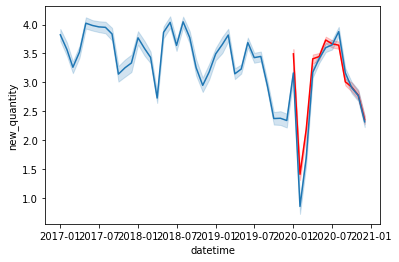

In [ ]:
new_data['new_quantity'] = pred_lgb
sns.lineplot(data = new_data, x='datetime', y='new_quantity', color= 'r')
sns.lineplot(data = df_new, x='date', y='quantity')

We got very good fit on the regenerated data!!!

## Predict test set  on best model

In [ ]:
X_test = X_val.copy()
X_test['Year'] = 2021
X_test

,Year,Month,item_id,brand_id,brandfamily_id,package_id,info_id,order_id,user_id,province_id,city_id
datetime,,,,,,,,,,,
2020-01-11,2021,1,1,6,1,1,3,64154,438,0,18
2020-01-11,2021,1,1,14,1,1,3,64154,438,0,18
2020-04-01,2021,4,1,6,1,1,3,23296,438,0,18
2020-04-01,2021,4,1,14,1,1,3,23296,438,0,18
2020-04-01,2021,4,1,6,1,1,3,52920,493,0,18
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2021,9,12,19,3,4,11,52082,18,0,10
2020-09-26,2021,9,12,19,3,4,11,11453,450,0,10
2020-09-11,2021,9,12,19,3,4,11,58771,262,0,10


Generate new test set based on validation set as it is the nearest period

In [ ]:
params = {
         "objective" : "regression",
         "metric" : "rmse",
         "num_leaves" : 100,
         "learning_rate" : 0.005,
         "bagging_fraction" : 0.7,
         "feature_fraction" : 0.5,
         "bagging_frequency" : 6,
         "bagging_seed" : 42,
         "verbosity" : 1,
         "seed": 42,
         }

lgtrain = lgb.Dataset(features, label= target)
lgval = lgb.Dataset(X_val, label=y_val)
evals_result = {}
model = lgb.train(params, lgtrain, 5000

                  )
    
pred_final = model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
X_test['final'] = pred_final
X_test.insert(0, 'date', pd.to_datetime(X_test[['Year', 'Month']].assign(DAY=1))) 
X_test

,date,Year,Month,item_id,brand_id,brandfamily_id,package_id,info_id,order_id,user_id,province_id,city_id,final
datetime,,,,,,,,,,,,,
2020-01-11,2021-01-01,2021,1,1,6,1,1,3,64154,438,0,18,1.252861
2020-01-11,2021-01-01,2021,1,1,14,1,1,3,64154,438,0,18,1.066516
2020-04-01,2021-04-01,2021,4,1,6,1,1,3,23296,438,0,18,1.284922
2020-04-01,2021-04-01,2021,4,1,14,1,1,3,23296,438,0,18,1.091614
2020-04-01,2021-04-01,2021,4,1,6,1,1,3,52920,493,0,18,1.494576
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,2021-09-01,2021,9,12,19,3,4,11,52082,18,0,10,1.305950
2020-09-26,2021-09-01,2021,9,12,19,3,4,11,11453,450,0,10,1.182631
2020-09-11,2021-09-01,2021,9,12,19,3,4,11,58771,262,0,10,1.070081


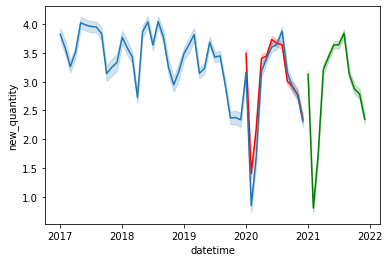

In [ ]:
new_data['new_quantity'] = pred_lgb
sns.lineplot(data = new_data, x='datetime', y='new_quantity', color= 'r')
sns.lineplot(data = X_test, x='date', y='final', color= 'g')
sns.lineplot(data = df_new, x='date', y='quantity')

Train data on whole data set but not train dataset. The result is too similar, potential of overfitting. Consider other methods or change our test data(not resamplling from existing data)